In [171]:
import numpy as np
import math as math
# import collections

import cv2 as cv
from imageio import imread
import matplotlib.pyplot as plt


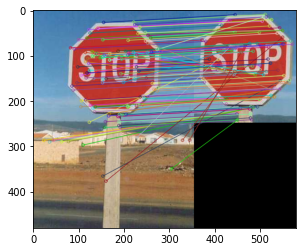

([<KeyPoint 0x12facdae0>,
  <KeyPoint 0x12facd0c0>,
  <KeyPoint 0x12facd990>,
  <KeyPoint 0x12facd150>,
  <KeyPoint 0x12facdba0>,
  <KeyPoint 0x12facd750>,
  <KeyPoint 0x12facdc30>,
  <KeyPoint 0x12facdc90>,
  <KeyPoint 0x12fad2d50>,
  <KeyPoint 0x12fad25a0>,
  <KeyPoint 0x12fad2270>,
  <KeyPoint 0x12fad2d80>,
  <KeyPoint 0x12fad2210>,
  <KeyPoint 0x12fad2420>,
  <KeyPoint 0x12fad2bd0>,
  <KeyPoint 0x12fad2b40>,
  <KeyPoint 0x12fad22d0>,
  <KeyPoint 0x12fad2f00>,
  <KeyPoint 0x12fad2f60>,
  <KeyPoint 0x12fad2990>,
  <KeyPoint 0x12fad2870>,
  <KeyPoint 0x12fad2ba0>,
  <KeyPoint 0x12fad29f0>,
  <KeyPoint 0x12fad2a20>,
  <KeyPoint 0x12fad2c00>,
  <KeyPoint 0x12fad2f30>,
  <KeyPoint 0x12fad2630>,
  <KeyPoint 0x12fad2330>,
  <KeyPoint 0x12fad2ab0>,
  <KeyPoint 0x12fad21b0>,
  <KeyPoint 0x12f877db0>,
  <KeyPoint 0x12f877f30>,
  <KeyPoint 0x12f877390>,
  <KeyPoint 0x12f8774b0>,
  <KeyPoint 0x12f877c60>,
  <KeyPoint 0x12f877570>,
  <KeyPoint 0x12f8777b0>,
  <KeyPoint 0x12f877660>,
  <KeyPoint 

In [172]:
# credit: I consulted opencv's documentation: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

# 1. figure out how to extract interest point operators
# 2. figure out how to compute the corresponding SIFT descriptors.

reference_image = imread('stopsign/stop-reference.jpg')
input_image = imread('stopsign/stop1.jpg')

sift = cv.SIFT_create()
ref_keypoints, ref_descriptors = sift.detectAndCompute(reference_image, None)
# keypoints, descriptors

# 3. Implement robust matching of SIFT descriptors
# credit: I consulted opencv's documentation: https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
# this finished step 1 of the outline


def matching (input_image,reference_image, match_threshold=0.8):
    ref_keypoints, ref_descriptors = sift.detectAndCompute(reference_image, None)
    keypoints, descriptors = sift.detectAndCompute(input_image, None)
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors,ref_descriptors,k=2)

    # Apply ratio test
    good = []
    good_ref = []
    good_match = []
    # apply ratio test
    for m,n in matches:
        if m.distance < match_threshold * n.distance:
            good.append(keypoints[m.queryIdx])
            good_ref.append(ref_keypoints[m.trainIdx])
            good_match.append([m])

    # cv.drawMatchesKnn expects list of lists as matches.
    img = cv.drawMatchesKnn(input_image, keypoints, reference_image, ref_keypoints,good_match, None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img),plt.show()
    return good, good_ref

matching(input_image=input_image, reference_image=reference_image, match_threshold=0.8)

In [173]:
#credit: http://amroamroamro.github.io/mexopencv/matlab/cv.SIFT.detectAndCompute.html for understanding keypoints and descriptors 
#4.find the corners of the bounding rectangles in the reference image
# then use this to find the bounding rectangles in the input image
# observe the equation is given by 
# transformation = point + scale_input/scale_ref * rotation
# where rotation is given by offset * rotation matrix of the difference of angles
# the result is the "corner" of input image (lower left, upper right of the image) that will get voted on in step3.
# this provides the query that supports the lookup operation described in step 2 
def transform_bounding_corners (reference_image, input_keypoint, ref_keypoint):
    # compute the height and width of the image
    height, width = reference_image.shape[:2]

    # compute the coordinates of upper right and lower left for the parameterized bounding box
    # upper_right = np.array((width, height))
    # lower_left = np.array((0,0))
    ### image y axis is inverted, hence
    upper_right = [width, 0]
    lower_left = [0,height]
    # upper_right = np.array((width, 0))
    # lower_left = np.array((0,height))
    
    # for hough transform
    corners = np.array([upper_right, lower_left]) 
    offset = corners - ref_keypoint.pt
    angle_radian = np.deg2rad(input_keypoint.angle - ref_keypoint.angle)
    rotation_matrix = np.array([
        [math.cos(angle_radian), -math.sin(angle_radian)],
        [math.sin(angle_radian),math.cos(angle_radian)]
    ]
    )
    rotate = offset @ rotation_matrix.T
    
    transformation = input_keypoint.pt + (input_keypoint.size / ref_keypoint.size) * rotate
    return transformation

In [174]:
#5. apply Hough Transform (counting votes)
# I consulted https://numpy.org/doc/stable/reference/generated/numpy.histogram.html for accumulator array
# we use corners as parameters for votes
# filter out key points using hough transform by voting on the corners

# this finishes step 3 of the outline by iteratively looking up the query and counting the votes. 
def hough_transform (reference_image, input_keypoints, ref_keypoints, num):
    #initialize the vote counter 
    corners = []
    
    #flatten the coordinate of the corners
    for input_keypoint, ref_keypoint in zip(input_keypoints, ref_keypoints):
        corners.append(transform_bounding_corners(reference_image,input_keypoint=input_keypoint, ref_keypoint=ref_keypoint).flatten())
    corners = np.array(corners)
     
    # assert len(corners) == 4

    # let each coordinate vote on the range of vertices to be included
    # to find multiple, after each iteration, eliminate the most counted coordinates
    # 
    votes = []
    for i in range(corners.shape[1]): 
        _,bins = np.histogram(corners[:,i], bins = num)
        vote_i = np.digitize(corners[:,i], bins, right=False)
        votes.append(vote_i)
    votes = np.array(votes).T
    # now we have collected the  voting for the range of the corners (how do I make this precise instead of the range?)
    # count the voting of the ranges, then select the points with the mostly selected range.


    # counter = collections.Counter(vote)
    # print(counter)
    
    counter = counting_vote(tuple(tuple(vote) for vote in votes))
    most_common = np.array(max(counter, key = counter.get))
    
    indices = []
    for i in range(votes.shape[0]):
        if votes.tolist()[i] == most_common.tolist():
            indices.append(i)
    
    input_points = []
    ref_points = []
    for i in indices:
        input_points.append(input_keypoints[i].pt)
        ref_points.append(ref_keypoints[i].pt)
    input_points = np.array(input_points).reshape(-1,1,2)
    ref_points = np.array(ref_points).reshape(-1,1,2)
    
    return input_points, ref_points
    
    

# simple program for counting list among lists
# credit to StackExchange for the use of counter:https://stackoverflow.com/questions/2161752/how-to-count-the-frequency-of-the-elements-in-an-unordered-list
def counting_vote (lists):
    freq = {}
    for element in lists:
        if (element in freq):
            freq[element] += 1
        else:
            freq[element] = 1
    return freq

In [175]:
# find homography given the filtered key points
# this finishes step 4 of the outline
def find_homography(src_pts, dst_pts):
    # source: https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
    M, mask =  cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    indices = []
    for i,match in enumerate(matchesMask):
        if match == 1:
            indices.append(i)
    homography_matrix, mask = cv.findHomography(src_pts[indices], dst_pts[indices], cv.RANSAC, 5.0)
    return homography_matrix


height, 248
width: 225
corner_vertices: [[[  0.   0.]]

 [[225.   0.]]

 [[225. 248.]]

 [[  0. 248.]]]


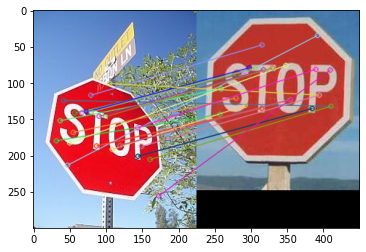

array([[ 13.170885,  60.539783],
       [178.1961  , 124.44176 ],
       [201.29773 , 306.6902  ],
       [-17.103554, 284.3082  ]], dtype=float32)

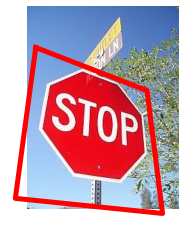

In [176]:
# apply homography to the bounding rectangle to get the final rectangle
# this finishes step 5 of the outline
def detect_image(reference_image, input_image,num):
    height, width = reference_image.shape[:2]
    print("height,",height)
    print("width:", width)
    corner_vertices = np.array([
        [0,0],
        [width,0],
        [width,height],
        [0,height]
    ]).astype(np.float32).reshape(-1,1,2)
    # corner_vertices = np.vstack([
    #         (0, 0),
    #         (width, 0),
    #         (width, height),
    #         (0, height)
    #     ]).astype(np.float32).reshape(-1,1,2)
    print("corner_vertices:" ,corner_vertices)
    input_keypoints, ref_keypoints = matching(reference_image=reference_image, input_image=input_image)
    input_points, ref_points = hough_transform(reference_image=reference_image,input_keypoints=input_keypoints, ref_keypoints=ref_keypoints,num=num)
    homography_matrix = find_homography(src_pts=ref_points, dst_pts=input_points)
    # source: https://www.programcreek.com/python/example/89377/cv2.perspectiveTransform
    bounding_rectangle = cv.perspectiveTransform(corner_vertices, homography_matrix).squeeze()
    
    # bounding_box = 
    
# todo: refactor
    corner_vertices = corner_vertices.squeeze()
    # xs = list(corner_vertices[:, 0].flatten()) + [corner_vertices[0, 0]]
    # ys = list(corner_vertices[:, 1].flatten()) + [corner_vertices[0, 1]]
    xs = list(bounding_rectangle[:, 0].flatten()) + [bounding_rectangle[0, 0]]
    ys = list(bounding_rectangle[:, 1].flatten()) + [bounding_rectangle[0, 1]]
    plt.imshow(input_image)
    plt.axis('off')
    plt.plot(xs, ys, 'r', linewidth=5)

    return bounding_rectangle

# input_image = imread('stopsign/stop1.jpg')
# detect_image(reference_image=reference_image, input_image= input_image, num=3)

# input_image = imread('stopsign/stop2.jpg')
# detect_image(reference_image=reference_image, input_image= input_image, num=3)

# input_image = imread('stopsign/stop3.jpg')
# detect_image(reference_image=reference_image, input_image= input_image, num=3)

# input_image = imread('stopsign/stop4.jpg')
# detect_image(reference_image=reference_image, input_image= input_image, num=3)

input_image = imread('stopsign/stop5.jpg')
detect_image(reference_image=reference_image, input_image= input_image, num=3)





The classical Hough Transform only applies to parametrizied feature, so we can apply this to 